## **Análisis de clientes utilizando K-means**

En este notebook se realiza el análisis de datos de clientes de un mall. El dataset contiene información de tarjetas de membresía, que tiene algunos datos básicos de los clientes, como ID de cliente, edad, sexo, ingresos anuales y puntaje de gastos. El puntaje de gasto es una variable que se le asigna al cliente en función de sus parámetros definidos, como el comportamiento del cliente y los datos de compra.

Dataset disponible en: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

### **1. Importación de librerias y de los datos**

In [ ]:
# importar librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# herramientas
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# escalamiento y normalizacion
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
# imputers
from sklearn.impute import SimpleImputer
# metricas
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
# mejoras
from sklearn.model_selection import GridSearchCV
# reduccion
from sklearn.decomposition import PCA
# cluster
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# datos y conversion a dataframe
df = pd.read_csv('Mall_Customers.csv')
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

### **2. Exploración y limpieza de los datos**

En esta sección se realiza un análisis exploratorio del set de datos con el objetivo de comprenderlos. En el análisis se busca identificar datos faltantes, duplicados, outliers, inconsistencia en datos categóricos y se de ser necesario se aplican técnica de imputación para los datos faltantes y outliers.

In [3]:
# df
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
# tipo de datos
print("Tipos de datos del dataframe")
df.dtypes

Tipos de datos del dataframe


CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Los datos disponibles en el dataset son del tipo numérico a excepción de gender.

In [6]:
# info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
# df
df.shape

(200, 5)

El dataset contiene 200 filas y 5 columnas de datos.

In [8]:
# estadisticas
print("Estadistica descriptiva del dataset")
df.describe()

Estadistica descriptiva del dataset


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


A continuación se busca identificar datos faltantes en el dataframe.

In [9]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df.shape[0]-df.isnull().sum(axis=0)

# cantidad de datos que si son na
qna=df.isnull().sum(axis=0)

# proporcion de datos con na y sin na
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)

# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)

# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
CustomerID,200,0,0.0
Gender,200,0,0.0
Age,200,0,0.0
Annual Income (k$),200,0,0.0
Spending Score (1-100),200,0,0.0


Se observa que el dataset no contiene datos faltantes.

In [10]:
# duplicados
df.duplicated().sum()

0

El dataset no contiene datos duplicados.

Se procede a visualizar la distribución de los datos.

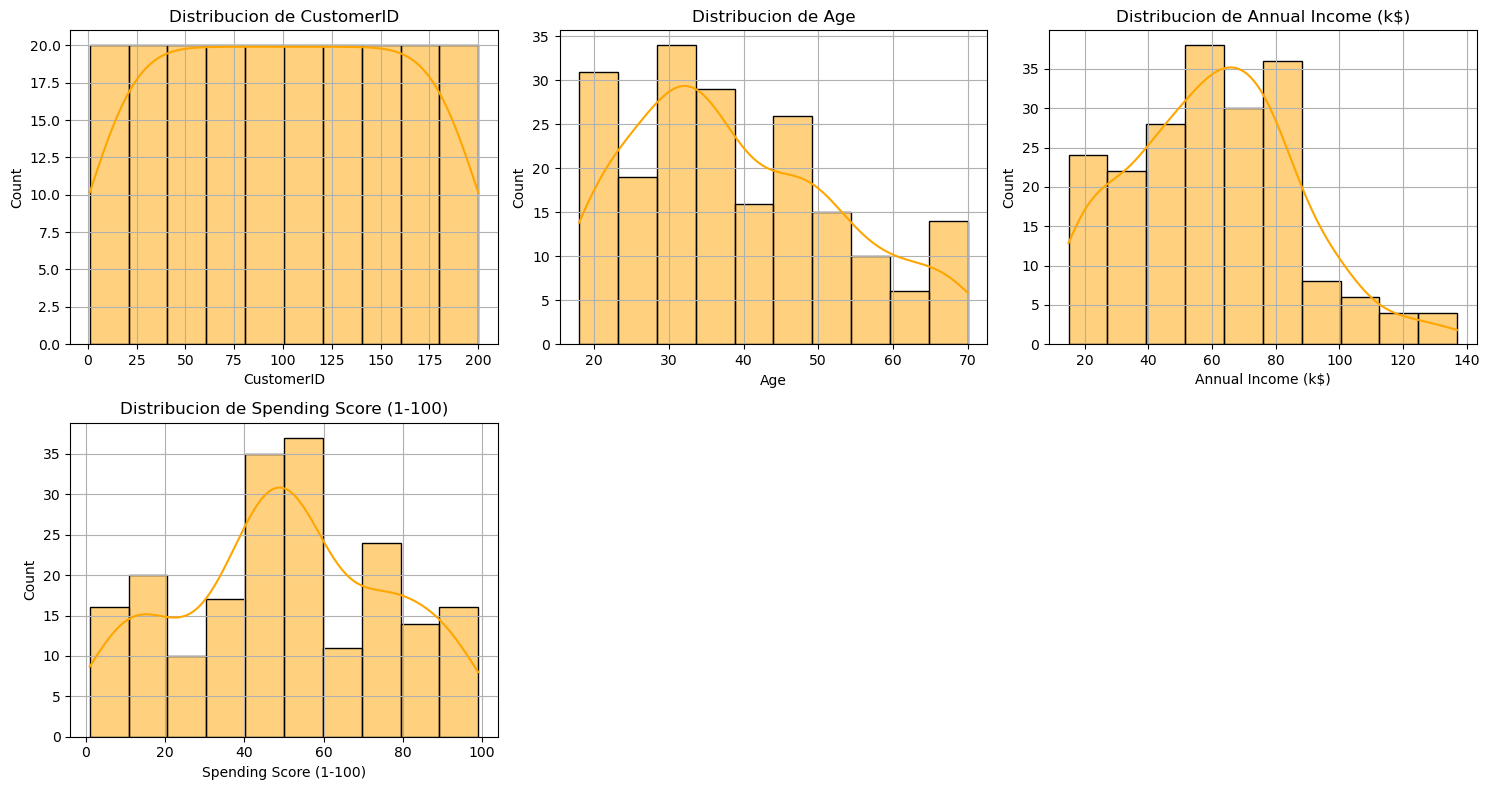

In [11]:
# numericas
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# numero de columnas y filas
cols = 3
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# distribucion de los datos
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.histplot(df[col], kde=True, color="orange", bins=10)  
    plt.title(f"Distribucion de {col}")
    plt.tight_layout()
    plt.grid()

plt.show()

A continuación, se procede a visualizar outliers en los datos utilizando boxplots.

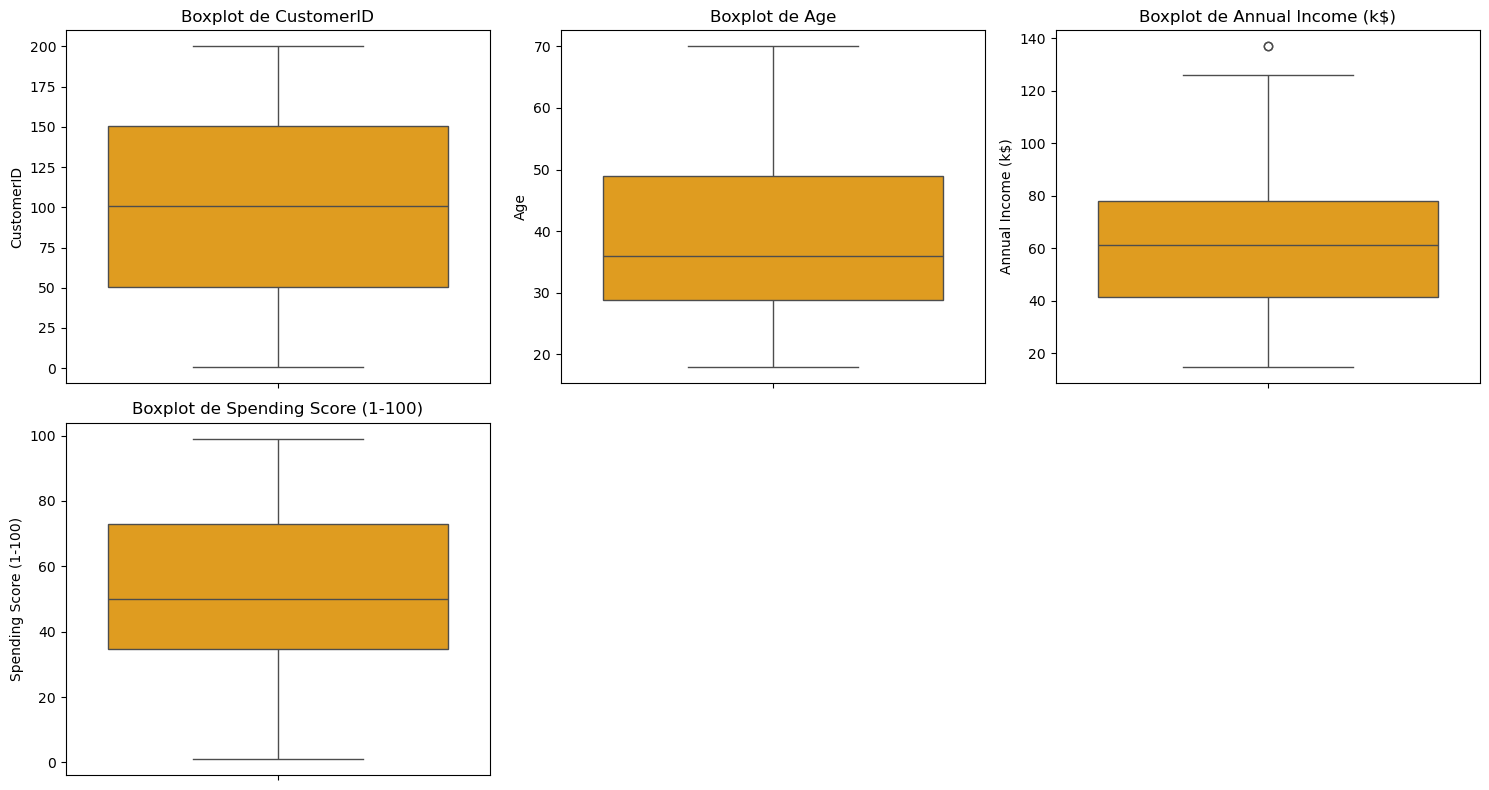

In [12]:
# numericas
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# numero de columnas y filas
cols = 3
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# crear boxplots 
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.boxplot(y=df[col], color="orange")
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()

plt.show()

En los boxplots se logra visualizar que en el set de datos no hay outliers.

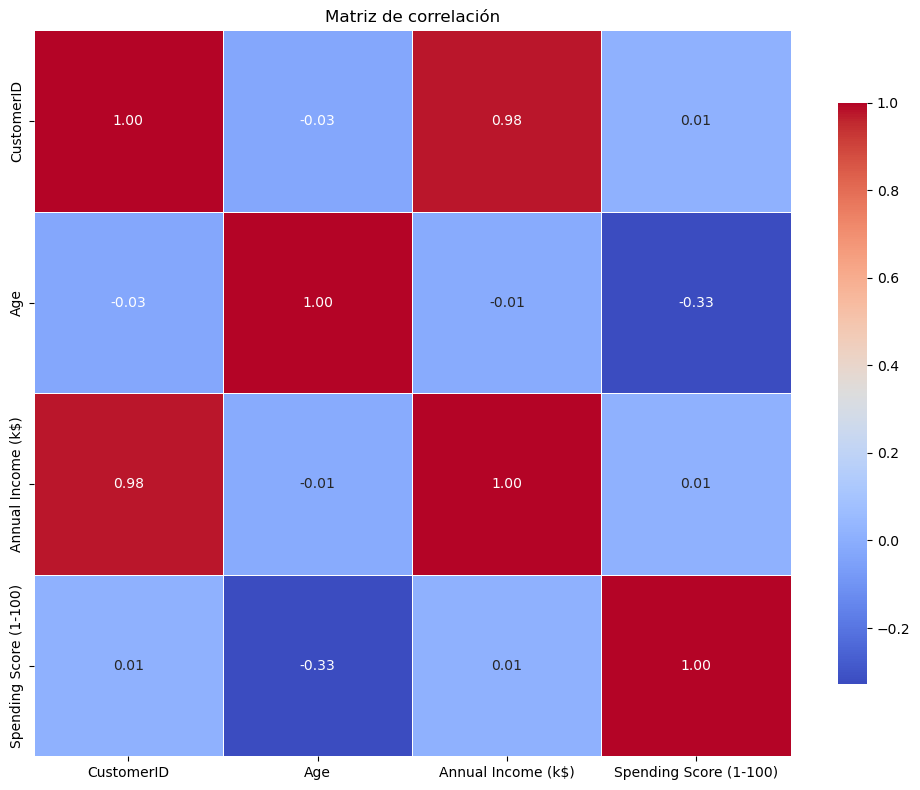

In [13]:
# variables numéricas
numerical_columns = df.select_dtypes(include=['int','float'])

# matriz de correlación
correlation_matrix = numerical_columns.corr()

# mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8})
plt.title('Matriz de correlación')

# grafico
plt.tight_layout()
plt.show()

Se observan correlaciones importantes entre las variables. 

### **3. Aplicación de K-means**

Se aplica K-means extrayendo dos variables importantes ‘Annual Income (k$)’ y ‘Spending Score (1-100)’ ya que representan características importantes relacionadas con el comportamiento de compra.

In [52]:
# extraer
df_selected = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# resultado
df_selected.head(5)

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


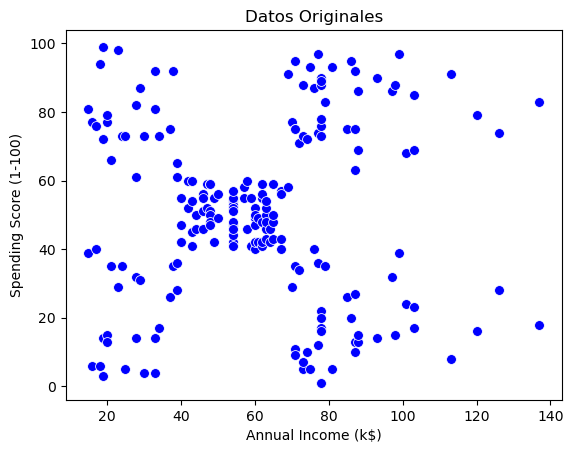

In [53]:
# distribucion original
sns.scatterplot(data=df_selected, x='Annual Income (k$)', y='Spending Score (1-100)', s=50, color='blue')
plt.title("Datos Originales")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

Para aplicar K-means, se aplica primeramente el escalamiento

In [54]:
# escalamiento
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

Inicialmente, se aplicara K-means con un numero de clusters arbitrario, por ejemplo,3,4 y 5.

In [55]:
# cluster 3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_scaled)

c:\Users\Admin\miniconda3\envs\datascience\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [56]:
# predecir
y_kmeans = kmeans.predict(df_scaled)

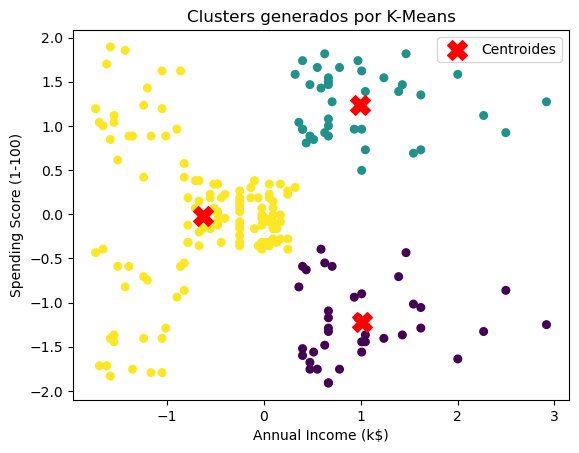

In [57]:
# Visualizar los clusters generados por K-Means
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=y_kmeans, s=30, cmap='viridis')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title("Clusters generados por K-Means")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.show()

Utilizando 3 clusters, se observa que los datos se encuentran bastante dispersos.

In [58]:
# cluster 4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_scaled)

c:\Users\Admin\miniconda3\envs\datascience\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [59]:
# predecir
y_kmeans = kmeans.predict(df_scaled)

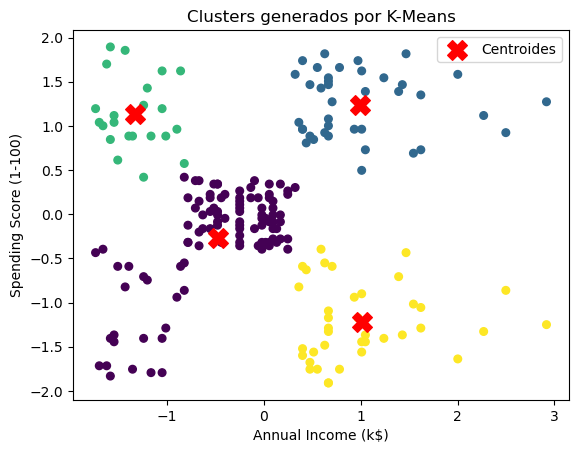

In [60]:
# Visualizar los clusters generados por K-Means
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=y_kmeans, s=30, cmap='viridis')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title("Clusters generados por K-Means")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.show()

De igual forma se mantienen alejados.

In [61]:
# cluster 5
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_scaled)

c:\Users\Admin\miniconda3\envs\datascience\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [62]:
# predecir
y_kmeans = kmeans.predict(df_scaled)

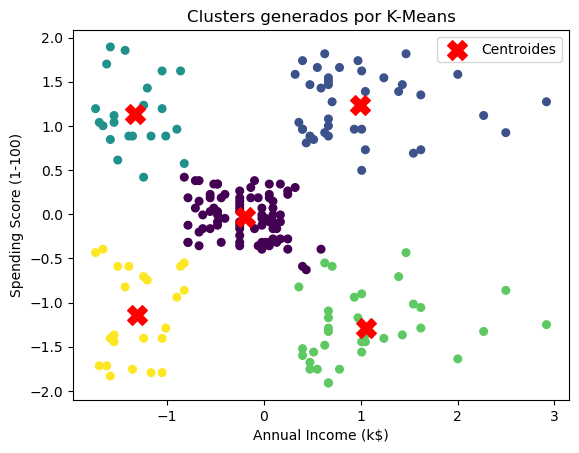

In [63]:
# Visualizar los clusters generados por K-Means
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=y_kmeans, s=30, cmap='viridis')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title("Clusters generados por K-Means")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.show()

Cuando se utiliza 5 clusters, se observa una buena definicion de los grupos, ya que tienen caracteristicas propias distintivas. Si bien, entre algunos de ellos no hay mucha distancia, igual logran representar las diferencias entre los grupos. 

En el contexto del negocio, la separación de los clústeres sugiere que estas dos variables, ingreso anual y puntaje de gasto, son efectivas para identificar patrones y segmentos claros dentro de los clientes.

Se puede observar tambien que la mayoria de los clientes se centran en el centro de la figura, es decir, un ingreso anual regular y gastos tambien regulares.

Se busca encontrar el numero de clusters optimo utilizando el metodo del codo y silhouette_scores

c:\Users\Admin\miniconda3\envs\datascience\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\datascience\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\datascience\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\datascience\Lib\site-packages\sklearn\cluster\_kmea

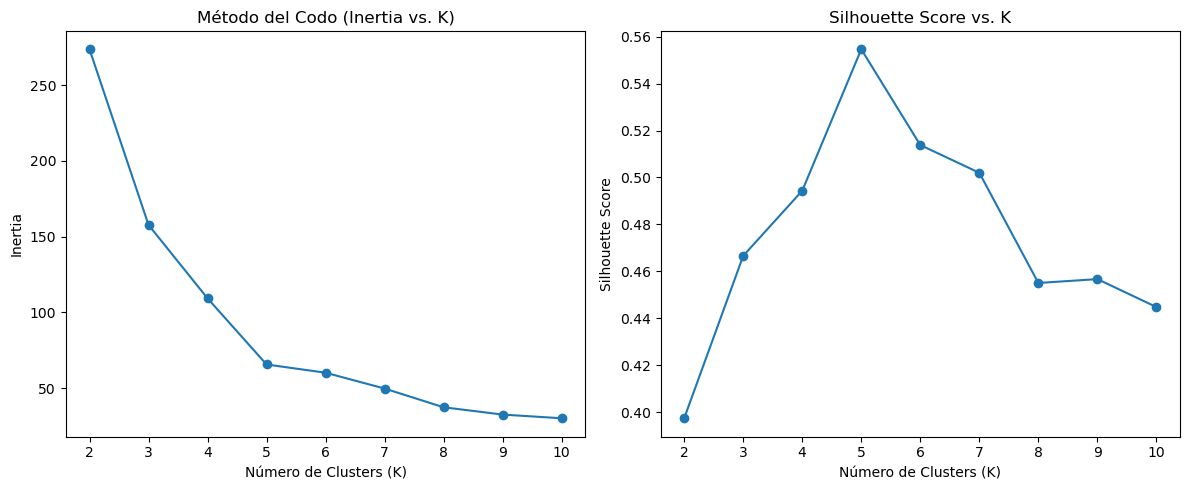

In [64]:
# Calcular Inertia y Silhouette Score para diferentes valores de K
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Crear gráficos
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de Inertia
ax[0].plot(k_values, inertia, marker='o')
ax[0].set_title('Método del Codo (Inertia vs. K)')
ax[0].set_xlabel('Número de Clusters (K)')
ax[0].set_ylabel('Inertia')

# Gráfico de Silhouette Score
ax[1].plot(k_values, silhouette_scores, marker='o')
ax[1].set_title('Silhouette Score vs. K')
ax[1].set_xlabel('Número de Clusters (K)')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

En ambos casos, se observa que el numero recomendable de clusters es de 5. Y de hecho, es asi como tambien se observa en los siguientes graficos, ya que al aplicar clusters de 8 los datos se van segmentando pero ya no de una manera eficiente. Al aplicar 8 clusters ya no se observa una distincion marcada entre los grupos, pareciera que ya hay un solapamiento y se dividen los datos en demasiados grupos de manera inncesaria.

In [65]:
# cluster 8
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(df_scaled)

c:\Users\Admin\miniconda3\envs\datascience\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(random_state=42)

In [66]:
# predecir
y_kmeans = kmeans.predict(df_scaled)

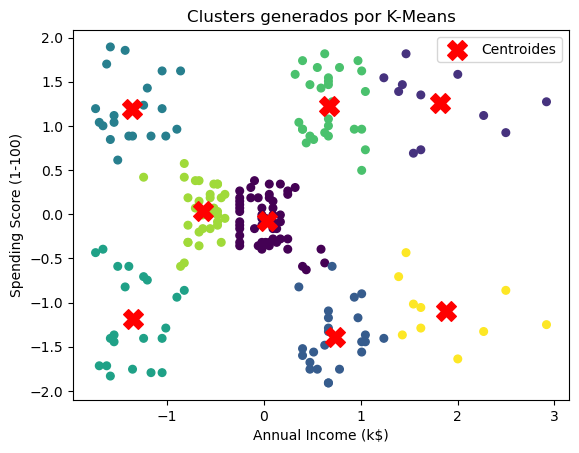

In [67]:
# Visualizar los clusters generados por K-Means
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=y_kmeans, s=30, cmap='viridis')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title("Clusters generados por K-Means")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.show()